# 비지도 학습 예제 1

#### 와인 품질 데이터로 클러스터링을 활용한 품질 분류

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# 1. 데이터 불러오기
df = pd.read_csv('winequality-red.csv')
print("✅ 데이터 로드 완료")
print(df.head())

✅ 데이터 로드 완료
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9

In [3]:
# 2. 주요 특성 선택
features = df.drop('quality', axis=1)  # quality 제외한 화학적 특성만 사용
print(features.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


In [4]:
# 3. 정규화 (표준화)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [5]:
# 4. K-Means 클러스터링 (클러스터 수: 3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

print("클러스터 분포:", np.bincount(clusters))

클러스터 분포: [722 502 375]


In [6]:
# 5. 클러스터 결과를 데이터프레임에 추가
df['Cluster'] = clusters

print(df[['quality', 'Cluster']].head())

   quality  Cluster
0        5        0
1        5        2
2        5        0
3        6        1
4        5        0


In [7]:
# 6. 각 클러스터별 평균 특성 비교
cluster_means = df.groupby('Cluster').mean(numeric_only=True)

print(cluster_means)

         fixed acidity  volatile acidity  citric acid  residual sugar  \
Cluster                                                                 
0             7.189889          0.609342     0.123047        2.214058   
1            10.067131          0.405080     0.469761        2.582570   
2             8.155467          0.535173     0.289680        3.105467   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
Cluster                                                                   
0         0.078553            13.507618             34.894737  0.995896   
1         0.100460            10.888446             30.627490  0.997574   
2         0.087235            27.108000             89.954667  0.997276   

               pH  sulphates    alcohol   quality  
Cluster                                            
0        3.405762   0.609224  10.494044  5.552632  
1        3.195040   0.752131  10.724037  5.960159  
2        3.284267   0.626533   9.883156  5.362667 

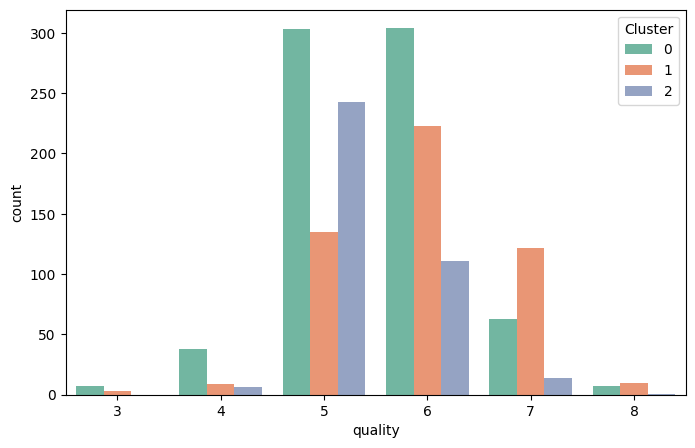

In [8]:
# 7. 클러스터별 품질 점수 분포 확인
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='quality', hue='Cluster', palette='Set2')

plt.show()

In [9]:
# 8. PCA로 2차원 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

In [10]:
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

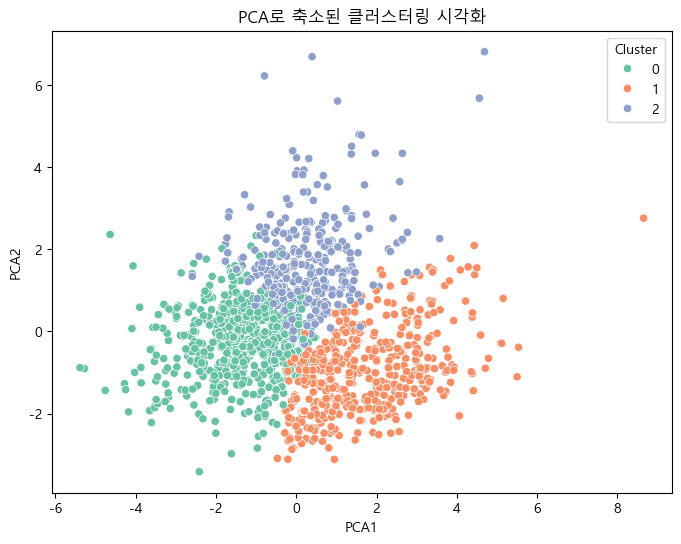

In [11]:
# 9. 결과 시각화
# 한글 폰트 설정 (그래프 깨짐 방지)
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('PCA로 축소된 클러스터링 시각화')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')

plt.show()

# 비지도 학습 예제2

##### 신용카드 거래 데이터(Credit Card Fraud Detection)

In [12]:
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, classification_report

In [13]:
# 1. 데이터 불러오기 및 전처리
# 데이터 불러오기
df = pd.read_csv("creditcard.csv")

# 원래 라벨은 잠깐 숨겨둠 (비지도 학습 시나리오)
true_labels = df['Class']
df_nolabel = df.drop('Class', axis=1)

# 정규화 (Time, Amount만 별도 처리)
scaler = StandardScaler()
df_nolabel[['Time', 'Amount']] = scaler.fit_transform(df_nolabel[['Time', 'Amount']])

In [14]:
# 2. Isolation Forest로 이상치 탐지
iso_forest = IsolationForest(n_estimators=100, contamination=0.0017, random_state=42)
iso_preds = iso_forest.fit_predict(df_nolabel)

# 결과 라벨 변환: -1 → 1 (이상치), 1 → 0 (정상)
iso_preds = np.where(iso_preds == -1, 1, 0)

In [ ]:
# 3. DBSCAN으로 이상치 탐지
dbscan = DBSCAN(eps=3, min_samples=5, n_jobs=-1)
db_preds = dbscan.fit_predict(df_nolabel)

# DBSCAN의 결과: -1은 이상치, 0 이상의 정수는 클러스터 번호
db_preds = np.where(db_preds == -1, 1, 0)

In [ ]:
# 4. 성능 비교 (라벨과 비교)
print("Isolation Forest")
print(confusion_matrix(true_labels, iso_preds))
print(classification_report(true_labels, iso_preds, digits=4))

print("\nDBSCAN")
print(confusion_matrix(true_labels, db_preds))
print(classification_report(true_labels, db_preds, digits=4))

In [ ]:
# 5. 시각화 (PCA 차원 축소)
from sklearn.decomposition import PCA

In [ ]:
# 차원 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_nolabel)

In [ ]:
# 데이터프레임 구성
viz_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
viz_df['True Label'] = true_labels
viz_df['IF'] = iso_preds
viz_df['DBSCAN'] = db_preds

In [ ]:
# Isolation Forest 시각화
plt.figure(figsize=(8,6))
sns.scatterplot(data=viz_df, x='PCA1', y='PCA2', hue='IF', palette='coolwarm', alpha=0.6)
plt.title('Isolation Forest 기반 이상 거래 탐지 결과')
plt.show()

In [ ]:
# DBSCAN 시각화
plt.figure(figsize=(8,6))
sns.scatterplot(data=viz_df, x='PCA1', y='PCA2', hue='DBSCAN', palette='coolwarm', alpha=0.6)
plt.title('DBSCAN 기반 이상 거래 탐지 결과')
plt.show()